# QOSF Problem-2: Optimizing Parametric Quantum Circuits

In this program, we will use a parametric circuit to generate a state that will return $|01\rangle$ and $|10\rangle$ with equal probability. 

As a bonus, we will see also see how to generate the state $\frac{1}{\sqrt{2}}\big(|01\rangle + |10\rangle\big)$ explicitly, instead of an arbitrary state of the form $\frac{1}{\sqrt{2}}\big(|01\rangle + e^{i\phi}|10\rangle\big)$. 

We will be coding using IBM's open-source Quantum SDK QISKit. 

In [1]:
import numpy as np 
np.random.seed(20)

# Creating Parametric Circuit

$|\Psi^+\rangle = \frac{1}{\sqrt{2}}\big(|01\rangle + |10\rangle\big)$ is a Bell-State, and, we can generate it from the $|00\rangle$ state using the $\textsf{H}, \textsf{X}$ and $\textsf{CX}$ gates. To parametrize this circuit, we will use the $\textsf{R}_y(\theta)$-gate in place of the $\textsf{H}$-gate and the $\textsf{R}_x(\phi)$-gate in place of the $\textsf{X}$-gate. Here, $\theta$ and $\phi$ are the parameters that we will find through optimization. 

Since, optimization has to be carried out by circuit-sampling... if we measure in the Computational-Basis, all states of the form $\frac{1}{\sqrt{2}}\big(|01\rangle + e^{i\phi}|10\rangle\big)$ will achieve the required probability distribution. So, if we want to construct the state $\frac{1}{\sqrt{2}}\big(|01\rangle + |10\rangle\big)$ explicitly, we need to measure in the Bell-Basis. This is easily achieved by appending a $\textsf{CX}$-gate and an $\textsf{H}$-gate before the measurement operation. 

In [2]:
# we will be building and running circuits in Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

**Note**: For the bonus problem, kindly uncomment the two lines for Bell-Basis measurement in the get_var_form() method below. 

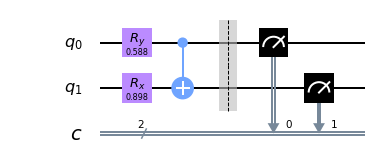

In [3]:
def get_var_form(params):
    qc = QuantumCircuit(2, 2)
    
    qc.ry(params[0], 0)
    qc.rx(params[1], 1)
    
    qc.cx(0, 1)
    qc.barrier()
    
    # use bell-basis measurement if we want to make the exact state (|01> + |10>)
    # uncomment the following two lines (qc.cx, qc.h) to do this
    # qc.cx(0, 1)
    # qc.h(0)
    
    qc.measure([0, 1], [0, 1])
    
    return qc

params = np.random.rand(2)

# visualizing complete circuit to check
get_var_form(params).draw(output='mpl')

## Target Distribution

For the computational basis measurement, the target probability distribution will be $\begin{bmatrix}0 &0.5 &0.5 &0\end{bmatrix}^T$. To generate the exact state $\frac{1}{\sqrt{2}}\big(|01\rangle + |10\rangle\big)$, the target distribution *after* Bell-Basis measurement will be $\begin{bmatrix}0 &1 &0 &0\end{bmatrix}^T$.

In [4]:
# target distribution for computational-basis measurement
target_distr = np.array([0, 0.5, 0.5, 0])

**Note**: For the bonus problem, kindly uncomment the required line below. 

In [16]:
# target distribution for bell-basis measurement
# uncomment this part for the bonus problem
# target_distr = np.array([0, 1, 0, 0])

# Optimization

## Configuring Simulation Backend

In [5]:
# Import Aer
from qiskit import Aer, execute
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')

## Configuring Noise Model

We will be using the **IBMQ_London** device's Gate-Errors and Noise-paramters to run our simulation. 

In [6]:
# For Noise Simulations
from qiskit.test import mock 
# this is the noise model of a REAL IBMQ device
fake_device = mock.FakeLondon()

# noise-model parameters to pass during simulation
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

## Creating Cost Function

In [7]:
# function to generate probability distribution from the dictionary of simulation results
def get_probability_distribution(counts):
    output_distr = np.zeros(4)
    
    for i in range(4):
        # generate reversed bit-string of i to access the counts dictionary
        output_string = format(i, '02b')[::-1]
        if output_string in counts:
            output_distr[i] = counts[output_string]
            # print(output_distr)
    
    # normalizing the probability distribution
    output_distr = output_distr/np.sum(output_distr)
    return output_distr

In [8]:
# this is the cost-function
def objective_function(params):
    # Obtain a quantum circuit instance for the paramters
    circ = get_var_form(params)    
    
    # Create a Quantum Program for execution with the given noise model
    result = execute(circ, backend, shots=NUM_SHOTS, 
                    noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates).result()
    
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts())
    
    # Calculate the cost as the Manhattan Distance distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(4)])
    
    return cost

In [9]:
# checking if everything works
NUM_SHOTS = 10
objective_function([0.5, 0.5])

2.0

# Configuring Optimizer

In [18]:
# importing optimizers
from qiskit.aqua.components.optimizers import COBYLA, SPSA, POWELL

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
INITIAL = np.array([0, 0])

# bounds of the parameters
BOUNDS = [(0, 2*np.pi)]*len(INITIAL)

# Running Optimizer

**Note**: If you want to see the results for any particular shots, kindly modify the SHOTS_LIST below. 

In [21]:
# we will see how the error in the final probability distribution evolves with the no. of circuit samplings
# modify this list if necessary
SHOTS_LIST = [1, 10, 100, 1000, 2000, 5000, 7000, 10000]

# importing time-library to time the simulation
import time

# all the simulation results will be stored in this list
all_results = []
for NUM_SHOTS in SHOTS_LIST:
    print("Sampling Circuit", NUM_SHOTS, "times.")
    
    # timing each simulation
    start = time.time()
    
    # Initialize the POWELL optimizer
    optimizer = POWELL() 
    
    #optimize circuit
    ret = optimizer.optimize(num_vars=2, objective_function=objective_function, 
                         variable_bounds=BOUNDS, initial_point=INITIAL)
    
    print("Circuit Optimized!", round(time.time()-start), "seconds elapsed.")
    all_results.append([NUM_SHOTS, ret[1], ret[0]])

Sampling Circuit 1 times.
Circuit Optimized! 2 seconds elapsed.
Sampling Circuit 10 times.
Circuit Optimized! 5 seconds elapsed.
Sampling Circuit 100 times.
Circuit Optimized! 7 seconds elapsed.
Sampling Circuit 1000 times.
Circuit Optimized! 6 seconds elapsed.
Sampling Circuit 2000 times.
Circuit Optimized! 4 seconds elapsed.
Sampling Circuit 5000 times.
Circuit Optimized! 14 seconds elapsed.
Sampling Circuit 7000 times.
Circuit Optimized! 15 seconds elapsed.
Sampling Circuit 10000 times.
Circuit Optimized! 30 seconds elapsed.


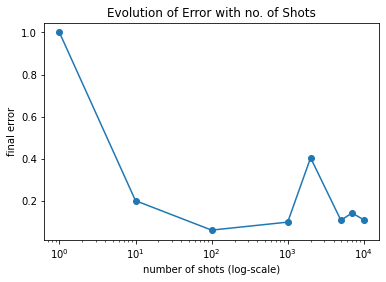

In [24]:
# plot the results for comparison 
from matplotlib import pyplot as plt

error = [all_results[i][1] for i in range(len(SHOTS_LIST))]

plt.plot(SHOTS_LIST, error, marker='o')
plt.xscale('log')
plt.xlabel('number of shots (log-scale)')
plt.ylabel('final error')
plt.title('Evolution of Error with no. of Shots')
plt.show()

## Additional

To see the output results and metrics for a particular simulation, the following code-block may be used. Just replace "i" below with the corresponding index of the shot-number in the SHOTS_LIST, that you want to see the results for. 

In [23]:
# give the index of the NUM_SHOTS in the SHOTS_LIST that you want to see the resuls for
i = 2
result = all_results[i]

# run circuits for the given parameters
qc = get_var_form(result[2])
counts = execute(qc, backend, shots=NUM_SHOTS, 
                    noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates).result().get_counts(qc)

# Obtain the output distribution using the final parameters
output_distr = get_probability_distribution(counts)

print("No. of Shots: ", result[0])
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", np.sum(np.abs(target_distr-output_distr)))
print("Parameters Found:", (result[2]/np.pi)%2, "\b*pi")

No. of Shots:  100
Target Distribution: [0.  0.5 0.5 0. ]
Obtained Distribution: [0.0483 0.4524 0.4905 0.0088]
Output Error (Manhattan Distance): 0.1142
Parameters Found: [1.48891422 0.9842754 ] *pi


## References
[1] Quantum Computation and Quantum Information, M. A. Nielsen & I. L. Chuang 

[2] Simulating Molecules using VQE, Qiskit Textbook 